#### The following notebook walks you thru the steps of Data Cleaning, Data Engneering and EDA.

___

In [1]:
# priting over 1 line of code within the same cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# importing required libraries
import pandas as pd
import numpy as np
from collections import defaultdict

# Visualization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# regext
import re

# extra
import warnings
warnings.filterwarnings('ignore')
import random
from collections import Counter
import time

In [3]:
df_3= pd.read_csv('../files/abused_addresses.csv')

In [4]:
df= pd.read_csv('../files/blocks_btc.csv')

FileNotFoundError: [Errno 2] File b'../files/blocks.csv' does not exist: b'../files/blocks.csv'

In [4]:
df.shape
df.info()

(1482749, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482749 entries, 0 to 1482748
Data columns (total 18 columns):
Unnamed: 0               1482749 non-null int64
hash                     1482749 non-null object
size                     1482749 non-null int64
virtual_size             1482749 non-null int64
version                  1482749 non-null int64
lock_time                1482749 non-null int64
block_hash               1482749 non-null object
block_number             1482749 non-null int64
block_timestamp          1482749 non-null object
block_timestamp_month    1482749 non-null object
input_count              1482749 non-null int64
output_count             1482749 non-null int64
input_value              1482749 non-null float64
output_value             1482749 non-null float64
is_coinbase              1482749 non-null bool
fee                      1482749 non-null float64
inputs                   1482749 non-null object
outputs                  1482749 non-null object
dtypes: bool

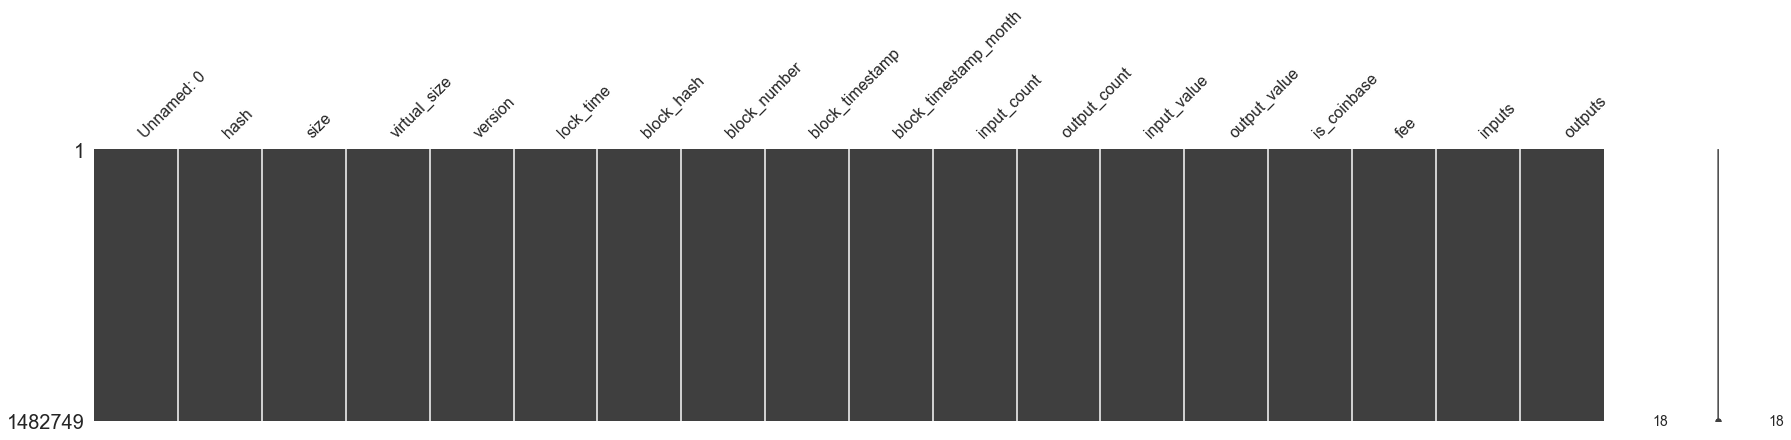

In [5]:
# checking if there are missing values

missingno.matrix(df, figsize = (30,5)) # no missing values
#missingno.matrix(df_1, figsize = (30,5)) # no missing values

In [6]:
# taking into account that tx that were recently mined have outputs but no inputs its clear that 
# there will be empty values in the input_value column.

nulls_percent_df = pd.DataFrame(df.isna().sum()/len(df)).reset_index()
nulls_percent_df.columns = ['column_name', 'nulls_percentage']
nulls_percent_df['amount']= list(df.isna().sum())
nulls_percent_df

,column_name,nulls_percentage,amount
0,Unnamed: 0,0.0,0
1,hash,0.0,0
2,size,0.0,0
3,virtual_size,0.0,0
4,version,0.0,0
5,lock_time,0.0,0
6,block_hash,0.0,0
7,block_number,0.0,0
8,block_timestamp,0.0,0
9,block_timestamp_month,0.0,0


In [7]:
# precisely... They are all coinbase tx aka. recently mined tx that got a reward

len(df[df['is_coinbase']== True])

698

<br>

#### Let's do some data exploration and data cleaning.

___

In [8]:
df.describe()

,Unnamed: 0,size,virtual_size,version,lock_time,block_number,input_count,output_count,input_value,output_value,fee
count,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06,1.482749e+06
mean,7.413740e+05,6.222218e+02,4.690850e+02,1.374295e+00,7.364162e+05,6.791807e+05,2.848061e+00,3.494734e+00,6.135567e+08,6.138509e+08,4.225701e+04
std,4.280329e+05,3.508912e+03,2.447686e+03,4.839404e-01,2.835900e+07,1.976228e+02,1.885039e+01,1.799278e+01,1.834746e+10,1.834745e+10,2.114416e+05
min,0.000000e+00,8.500000e+01,8.500000e+01,1.000000e+00,0.000000e+00,6.788290e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.706870e+05,2.230000e+02,1.680000e+02,1.000000e+00,0.000000e+00,6.790140e+05,1.000000e+00,1.000000e+00,4.482390e+05,4.289530e+05,1.342700e+04
50%,7.413740e+05,2.450000e+02,2.230000e+02,1.000000e+00,0.000000e+00,6.791780e+05,1.000000e+00,2.000000e+00,1.876934e+06,1.857018e+06,1.938300e+04
75%,1.112061e+06,3.730000e+02,2.570000e+02,2.000000e+00,0.000000e+00,6.793500e+05,1.000000e+00,2.000000e+00,1.778780e+07,1.785332e+07,2.794800e+04
max,1.482748e+06,2.244770e+05,1.431090e+05,2.000000e+00,4.236579e+09,6.795250e+05,1.351000e+03,4.327000e+03,1.272682e+12,1.272681e+12,2.191089e+07


In [11]:
# visualizing the df

df.head()

,index,Unnamed: 0,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,0,0,114e784709ebffef55d7d854d74108854c30e8d033f61f...,2581,2581,2,0,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,17,2,2036546.0,2015794.0,False,20752.0,"[{'index': 0, 'spent_transaction_hash': 'b836b...","[{'index': 0, 'script_asm': 'OP_HASH160 07b6f5..."
1410,1410,1410,2eadc3012d7e436c4841484ff4b858bde91ae756988368...,190,190,1,0,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,1,1,350314.0,348964.0,False,1350.0,"[{'index': 0, 'spent_transaction_hash': '732b8...","[{'index': 0, 'script_asm': 'OP_HASH160 b05671..."
1409,1409,1409,c1758deb5405ac826d0823b2cf7a4eff14663d45abb176...,191,110,2,0,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,1,1,3344220.0,3342298.0,False,1922.0,"[{'index': 0, 'spent_transaction_hash': 'e83d0...","[{'index': 0, 'script_asm': '0 6f331426cbd02b8..."
1408,1408,1408,4f2980ca294f9d1c5a105bef52caadcfc04bf93f2e1746...,247,166,2,678828,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,1,2,41927788.0,41918494.0,False,9294.0,"[{'index': 0, 'spent_transaction_hash': '3e0ef...","[{'index': 0, 'script_asm': 'OP_HASH160 51fade..."
1407,1407,1407,9b216431ff886113e67191b81f659bba2246257d3ca6c1...,418,256,2,0,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,2,2,1129561.0,1121927.0,False,7634.0,"[{'index': 0, 'spent_transaction_hash': 'c1724...","[{'index': 0, 'script_asm': 'OP_HASH160 523629..."


### Columns Description:

- |__Unnamed: 0__| -> Redundant column of the index. _'int64'_
- |__Hash__| -> The hash of this transaction. _'object'_
- |__Size__| -> The size of block data in bytes. _'int64'_
- |__Virtual size__| -> The virtual transaction size (differs from size for witness transactions). _'int64'_
- |__Version__| -> Protocol version specified in block which contained this transaction. _'object'_
- |__Lock time__| -> Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest. _'object'_
- |__Block hash__| -> Hash of the block which contains this transaction. _'int64'_
- |__Block number__| -> Number of the block which contains this transaction. _'int64'_
- |__block timestamp__| -> Timestamp of the block which contains this transaction. _'object'_
- |__Block timestamp month__| -> Month of the block which contains this transaction. _'int64'_
- |__Input count__| -> The number of inputs in the transaction. _'int64'_
- |__Output count__| -> The number of outputs in the transaction. _'int64'_
- |__Input value__| -> Total value of inputs in the transaction in satoshis. _'int64'_
- |__Output value__| -> Total value of outputs in the transaction in satoshis. _'int64'_
- |__Is coinbase__| -> Max amount of sets that can be played in a match. _'bool'_
- |__Fee__| -> The fee paid by this transaction in sats. _'float64'_
- |__Inputs__| -> Transaction inputs. _'object'_
- |__Outputs__| -> Transaction outputs. _'object'_

<br>

#### Checking all columns and changing the type in case it's needed

In [12]:
# index column and Unnamed

df.index
df['Unnamed: 0']

0               0
1410         1410
1409         1409
1408         1408
1407         1407
            ...  
1481402    580224
1481401    580223
1481400    580222
1481413    580235
1482748    581570
Name: Unnamed: 0, Length: 1482749, dtype: int64

In [11]:
# dropping redundant columns

df.drop(columns= ['Unnamed: 0'], inplace= True)

<br>

In [269]:
# size column and vsize column should be very similar

df['size'].value_counts()

223      140354
225      122358
224      100074
226       98294
247       60813
          ...  
82921         1
13834         1
9736          1
28161         1
57814         1
Name: size, Length: 15258, dtype: int64

In [14]:
len(df)/100


14827.49

In [15]:
df['size'].min()
df['size'].max()

224477

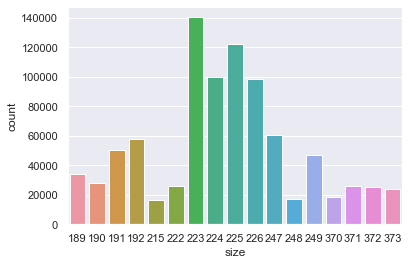

In [23]:
sns.countplot(x= 'size', data= df_rep)

In [24]:
# tx with very large size prolly exchanges moving large amount of funds from one cold wallet to the another.

len(df[df['size'] > 200000])
df[df['size'] > 200000].head()

15

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
27325,9150d31a5f62726af4a37ba1ee5650e861c0d19b704e56...,205944,91388,1,0,0000000000000000000015d9340dedc6c48e6be4794739...,678846,2021-04-12 02:52:40+00:00,2021-04-01,699,2,2.014212e+08,2.000464e+08,False,1374720.0,"[{'index': 0, 'spent_transaction_hash': '445e6...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
307730,23f125b1359ac4e3213a320e7ce1124042d331654ac5bc...,224431,99574,1,0,000000000000000000034c0c406bc63ab4c6f0530cf6ae...,678980,2021-04-13 01:17:33+00:00,2021-04-01,762,1,7.459861e+08,7.419902e+08,False,3995920.0,"[{'index': 0, 'spent_transaction_hash': '267bb...","[{'index': 0, 'script_asm': '0 baead3fe189cd53..."
306684,1e6a981fd2f7275d6232a218156f44ecf27b0f84d3dbff...,224477,99586,1,0,000000000000000000034c0c406bc63ab4c6f0530cf6ae...,678980,2021-04-13 01:17:33+00:00,2021-04-01,762,1,6.731933e+08,6.691974e+08,False,3995920.0,"[{'index': 0, 'spent_transaction_hash': 'cf9d6...","[{'index': 0, 'script_asm': '0 8854753243fd687..."
311232,ba300a8622e209e34ce1e85a30daaa3a04ec5325c506f6...,224448,99579,1,0,000000000000000000002ba30870d995d576b2b59fa153...,678982,2021-04-13 01:28:59+00:00,2021-04-01,762,1,1.233682e+09,1.229786e+09,False,3896022.0,"[{'index': 0, 'spent_transaction_hash': '57528...","[{'index': 0, 'script_asm': '0 bcd72162397bd11..."
569747,a601805ab2cdd45e1ee177325cc2bac5147d579d986e34...,224438,99576,1,0,0000000000000000000b70368126f54bcb71cc89d986a7...,679099,2021-04-13 21:41:23+00:00,2021-04-01,762,1,1.405084e+09,1.396693e+09,False,8391432.0,"[{'index': 0, 'spent_transaction_hash': 'fb5e4...","[{'index': 0, 'script_asm': '0 931185c71051bd9..."


<br>

In [25]:
# version - most nodes are using the version 1

df['version'].value_counts()

1    927764
2    554985
Name: version, dtype: int64

<br>

In [26]:
# locktime

df['lock_time'].value_counts()

0            1168276
679227          2940
679298          2847
679186          2525
679050          2382
              ...   
550655917          1
543152659          1
544547660          1
676587             1
538970111          1
Name: lock_time, Length: 2113, dtype: int64

In [27]:
df['lock_time'].mean()
df['lock_time'].max()

736416.2382210341

4236579363

In [28]:
df[df['lock_time'] > 679298].head()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
203,e6e4034506ef184cc34655c23c019c13475a46172577c6...,331,304,1,12388320,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,0,4,NaN,661806252.0,True,0.0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
569,f72d0195c82624dac07fba69b701ebd2b09b8384ede3f0...,346,181,2,548867413,0000000000000000000a74535081f831163fe6ebbcbb5c...,678829,2021-04-11 23:58:57+00:00,2021-04-01,1,2,16777215.0,16762223.0,False,14992.0,"[{'index': 0, 'spent_transaction_hash': '1d7bc...","[{'index': 0, 'script_asm': '0 61a287af11ec6a2..."
2278,9f626d5d165eba86cd575c6c5d23998a37048f41cb7631...,302,137,2,546626799,00000000000000000004d147c3f938ea7f8a2120f5e2b0...,678830,2021-04-12 00:11:12+00:00,2021-04-01,1,1,40627.0,29392.0,False,11235.0,"[{'index': 0, 'spent_transaction_hash': '6d4bb...","[{'index': 0, 'script_asm': '0 11750981369bcde..."
2551,2708e16d593ac9dbf74eb44d904144e984798464fc661b...,2401,2401,1,1618186042,00000000000000000004d147c3f938ea7f8a2120f5e2b0...,678830,2021-04-12 00:11:12+00:00,2021-04-01,16,1,113845238.0,113624393.0,False,220845.0,"[{'index': 0, 'spent_transaction_hash': '6795b...","[{'index': 0, 'script_asm': 'OP_HASH160 0c7a02..."
6210,07ba4c6de359620755d703a22e0984d735c628b2dd1a34...,314,149,2,551212354,000000000000000000051b16891443cbafc8fcb517bfb1...,678832,2021-04-12 00:59:20+00:00,2021-04-01,1,1,587245.0,567230.0,False,20015.0,"[{'index': 0, 'spent_transaction_hash': 'a5c44...","[{'index': 0, 'script_asm': '0 2369e0ccb9947e2..."


<br>

In [29]:
# blockhash --- nothing here i guess

df.block_hash.head()

0       0000000000000000000a74535081f831163fe6ebbcbb5c...
1410    0000000000000000000a74535081f831163fe6ebbcbb5c...
1409    0000000000000000000a74535081f831163fe6ebbcbb5c...
1408    0000000000000000000a74535081f831163fe6ebbcbb5c...
1407    0000000000000000000a74535081f831163fe6ebbcbb5c...
Name: block_hash, dtype: object

<br>

In [30]:
# there are approx 7k tx per block... and 1 block is mined approx every 10 min

df['block_number'].min()
df['block_number'].max()
(df['block_number'].max() - df['block_number'].min())

678829

679525

696

In [ ]:
df[df.duplicated() == 1]

In [17]:
# block 679250 is repeated

rows_rep= df[df.duplicated(subset= 'hash')].index
df.drop(rows_rep, inplace= True, axis= 0)

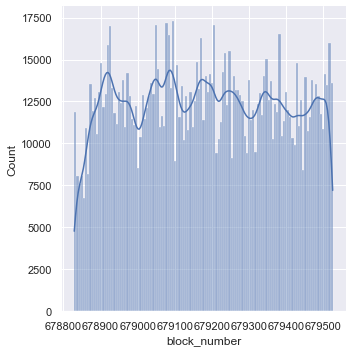

In [34]:
sns.displot(data=df, x='block_number', kde= True)

<br>

In [19]:
# converting to proper type block_timestamp

df['block_timestamp']= pd.to_datetime(df.block_timestamp).dt.tz_localize(None)

In [36]:
df['block_timestamp'].min()
df['block_timestamp'].max()

Timestamp('2021-04-11 23:58:57')

Timestamp('2021-04-16 23:57:57')

<br>

In [20]:
# check this column more in depth

df['block_timestamp_month'] = pd.to_datetime(df['block_timestamp_month'])

In [40]:
df['block_timestamp_month'].head()

0      2021-04-01
1410   2021-04-01
1409   2021-04-01
1408   2021-04-01
1407   2021-04-01
Name: block_timestamp_month, dtype: datetime64[ns]

<br>

In [41]:
# big majority of tx have 2 inputs

len(df['input_count'].value_counts())

709

In [42]:
print(len(df[df['input_count'] < 5]),'/',len(df))

1406842 / 1482749


In [43]:
a= [i  if i < 6 else 6 for i in df['input_count']]
Counter(a)

Counter({6: 59729,
         1: 1127980,
         2: 194085,
         3: 57328,
         5: 16178,
         4: 26751,
         0: 698})

In [44]:
df['input_count'].value_counts(normalize= True)[:5]

1    0.760736
2    0.130895
3    0.038663
4    0.018041
5    0.010911
Name: input_count, dtype: float64

<br>

In [45]:
# same happens with output... unless the UTXO is spent completely most outputs are 2 cuz of the change address
# prolly very big numbers of inputs/outputs come from mixers or exchanges

df['output_count'].value_counts()

2       945235
1       374938
3        56781
4        19747
5        11727
         ...  
419          1
421          1
424          1
427          1
4080         1
Name: output_count, Length: 485, dtype: int64

<br>

In [46]:
# amount of money sent in satoshis ! 

df['input_value'].describe()

count    1.482051e+06
mean     6.138457e+08
std      1.835178e+10
min      5.470000e+02
25%      4.494855e+05
50%      1.879290e+06
75%      1.781420e+07
max      1.272682e+12
Name: input_value, dtype: float64

In [21]:
df['input_value'].fillna(0, inplace= True)

In [48]:
df['input_value'].min()
df['input_value'].max()

0.0

1272681684153.0

<br>

In [49]:
# amount of coins received
# output_value = input_value - fee

df['output_value'].describe()

count    1.482749e+06
mean     6.138509e+08
std      1.834745e+10
min      0.000000e+00
25%      4.289530e+05
50%      1.857018e+06
75%      1.785332e+07
max      1.272681e+12
Name: output_value, dtype: float64

<br>

In [50]:
# mined tx or not. This happen with every new block or what is the same roughly every 10 mins

df['is_coinbase'].value_counts()

False    1482051
True         698
Name: is_coinbase, dtype: int64

In [51]:
# some miners decide to claim the fee paid by users in that block while other go only for the block reward in order
# to mantain the mining process more effectevely and quick

df[df['is_coinbase']== 1]['output_value'].mean()
df[df['is_coinbase']== 1]['output_value'].min()
df[df['is_coinbase']== 1]['output_value'].max()

714765807.8481375

625000000.0

847158432.0

<br>

In [52]:
# fee column

df['fee']

0          20752.0
1410        1350.0
1409        1922.0
1408        9294.0
1407        7634.0
            ...   
1481402    42247.0
1481401    24708.0
1481400    25909.0
1481413    21642.0
1482748    79856.0
Name: fee, Length: 1482749, dtype: float64

In [53]:
df['fee'].min()
df['fee'].max()

0.0

21910890.0

<br>

In [22]:
# converting columns values from satoshis to bitcoin
# satoshi is the minimum unit of bitcoin
# 1 bitcoin = 100.000.000 sats


df[['input_value', 'output_value', 'fee']]= df[['input_value', 'output_value', 'fee']].apply(lambda x: x/100000000)

<br>

#### Let's explore the most important columns for our analysis

___

These two columns contain the most precious information for our analysis. They show the input/output addresses plus how many sats ended up in which address after the user transacted. These will allow us to connect several addresses from input to output and make an infinite loop till there are no more addresses to scan. They are revealing info about where 'stolen' funds ended up. 

The format of the columns are a type of bigquery json and there's no easy workaround with that so there's a lenghty process of cleaning those columns to obtain the desirable results.

### Key and values description:

_INPUTS_ :
- |__index:__| -> (numeric) Index of the tx. 
- |__spent_transaction_hash:__| -> (string) identifier of the transaction. 
- |__spent_output_index:__| -> (string) created internally by the client interacting with the blockchain. 
- |__script_asm__| -> (string) String representation of the script public key.
- |__script_hex__| -> (string) Hex string of the script public key. 
- |__sequence__| -> (numeric) nSequence is a 4 byte input level feature. The original meaning of nSequence was to allow modification of transactions in the mempool. 
- |__required_signatures__| -> (numeric) The required signatures (always 1)
- |__type__| -> (string) The type of the script public key (e.g. witness_v0_keyhash or witness_v0_scripthash)
- |__address__| -> (json array) Basically amount of inputs.
- |__value__| -> (numeric) Amount of sats sent/received to that address

In [54]:
df['inputs'].iloc[0]

"[{'index': 0, 'spent_transaction_hash': 'b836bc9e4e2eb34520dded6a97db44b1a8edd86c017b6d6ee40f95c4130e50c2', 'spent_output_index': 63, 'script_asm': '304402202106a1a53e4756bbab1d36df6d06aacae843c049d17c88f200a1dc1a24145ac702201caa3476f1f026d0ec916de8699e3ae30b2b4c119f85a576bab530ac072ebd30[ALL] 028e530a084ef688c94a5383378057a72e793db520063567edf644d7007164550f', 'script_hex': '47304402202106a1a53e4756bbab1d36df6d06aacae843c049d17c88f200a1dc1a24145ac702201caa3476f1f026d0ec916de8699e3ae30b2b4c119f85a576bab530ac072ebd300121028e530a084ef688c94a5383378057a72e793db520063567edf644d7007164550f', 'sequence': 4294967295, 'required_signatures': 1, 'type': 'pubkeyhash', 'addresses': array(['1GVU5B4LeQ33Q3VrnLhmDAfUP8EP3f9mbJ'], dtype=object), 'value': Decimal('117340.000000000')}\n {'index': 1, 'spent_transaction_hash': '4c127c772bf484f2f9203eeac7e0e4b9bb029af6a35bb909f7826a011129b598', 'spent_output_index': 60, 'script_asm': '3045022100f88ef56ef82a73ac55cfe9834c6088fb3c081917efcd428946578ce8dfe00

_OUTPUTS_ :
- |__index:__| -> (numeric) Index of the tx. 
- |__script_asm__| -> (string) String representation of the script public key.
- |__script_hex__| -> (string) Hex string of the script public key. 
- |__required_signatures__| -> (numeric) The required signatures (always 1)
- |__type__| -> (string) The type of the script public key (e.g. witness_v0_keyhash or witness_v0_scripthash)
- |__address__| -> (json array) Basically amount of inputs.
- |__value__| -> (numeric) Amount of sats sent/received to that address

In [55]:
df['outputs'].iloc[0]

"[{'index': 0, 'script_asm': 'OP_HASH160 07b6f59a942758f37199246bce9f2bb5e9d16c31 OP_EQUAL', 'script_hex': 'a91407b6f59a942758f37199246bce9f2bb5e9d16c3187', 'required_signatures': 1.0, 'type': 'scripthash', 'addresses': array(['32Poq8NJmBKDt7eMGKDeTPBc3iw7jGZ3sf'], dtype=object), 'value': Decimal('1964880.000000000')}\n {'index': 1, 'script_asm': 'OP_HASH160 ab88d94e76e4cf78ee6c4111efcfcf321ed9df76 OP_EQUAL', 'script_hex': 'a914ab88d94e76e4cf78ee6c4111efcfcf321ed9df7687', 'required_signatures': 1.0, 'type': 'scripthash', 'addresses': array(['3HL1QmiZaAT85uRXuNGq2y7rYR4thhBubc'], dtype=object), 'value': Decimal('50914.000000000')}]"

<br>

#### Let's write a function to convert these 2 important columns into something that we can actually work with...

In [56]:
# This function converts the string on each road of the selected columns into a list of well-formed dictionaries.

def clean_columns(x, index):
    y = x[index]
    
    if y == "[]":
        return x
    chars_to_replace = "[{'}]\n( " # unnecessary characters that belonged to bigquery json format.

    words_to_replace = ["array", "dtype=object", "Decimal", ")index"] # 'change' chars that are useless. 

    
    for char in chars_to_replace:
        y = y.replace(char, "")

    for word in words_to_replace:
        y = y.replace(word, "")
        
    y = y.replace(")", "")

    inputs_dict = defaultdict(list)
    rep_text = y.split(":")
    inputs_dict[rep_text[0]].append(rep_text[1][0])
    for i, thing in enumerate(rep_text):
        if i == 0:
            continue
        thing = thing.split(",")
        
        if i == 1:
            last_thing = thing[1]
            #inputs_dict[last_thing] = []
        else:
            try:
                thing[0] = int(thing[0])
            except ValueError:
                pass
            
            inputs_dict[last_thing].append(thing[0])
            try:
                last_thing = thing[1]
            except IndexError as error:
                inputs_dict["values"].append(thing[0])

    inputs_dict["index"] = list(range(len(inputs_dict["required_signatures"])))
    inputs_dict["values"] = [float(value.replace("E", "e").split(".")[0]) for value in inputs_dict["values"]]
    inputs_dict["hash"] = [x[1]] * len(inputs_dict["index"])
    [inputs_dict.pop(key) for key in list(inputs_dict.keys()) if key not in ["hash", "sequence", "spent_output_index", "spent_transaction_hash", "type", "values", "addresses"]]
    #keeping only neccesary columns for our product
    
    
    return inputs_dict

In [57]:
# Let's test it

start = time.time()

outputs = df.apply(clean_columns, axis=1, index=-1) # parse "outputs" columns
inputs = df.apply(clean_columns, axis=1, index=-2) # parse "inputs" columns

print('This piece of code took: ',time.time() - start , 'to run')

This piece of code took:  365.32020378112793 to run


In [58]:
# exploring the recently created pandas series variables

inputs.head()
type(inputs.iloc[0])
inputs.iloc[0].keys()
inputs.iloc[0].values()

0       {'spent_transaction_hash': ['b836bc9e4e2eb3452...
1410    {'spent_transaction_hash': ['732b8e02e6c398718...
1409    {'spent_transaction_hash': ['e83d0d240fcaefd3e...
1408    {'spent_transaction_hash': ['3e0ef0674bf0ed1a9...
1407    {'spent_transaction_hash': ['c1724ddf47f200b7b...
dtype: object

collections.defaultdict

dict_keys(['spent_transaction_hash', 'spent_output_index', 'sequence', 'type', 'addresses', 'values', 'hash'])

dict_values([['b836bc9e4e2eb34520dded6a97db44b1a8edd86c017b6d6ee40f95c4130e50c2', '4c127c772bf484f2f9203eeac7e0e4b9bb029af6a35bb909f7826a011129b598', '4b4f0a9e039197b218a5ef967f1e9b46ab6862291334aa3b0c2fc8cf4e0b6700', 'cac79e959c266d24f5c3f26696a4daae5a9e792a7eb930d28d60c975d90c39db', 'bc08c4713fd0646d356fcac988e372bc24ec0dd81056b5f2d4c19de1322c3e11', 'd5d2db1b5f90731bf6326f1c84ee95d4a18ec002bb17a8f76516ef5a60269c8f', 'a82a4ac3af0304a9ce3a7fdff24d2a2b9411e35cb3840cc5bbaf27995cdbfffc', 'b55bfae08127fb9b3bf575a61f869b7e20712153dc1c860122cc2462739fd412', '5525e0b920f03238dd4444b13b81fd506c8ff2bb705d0ca64408f4e18117817b', '1769e3139ad38e873ecba3e4ef9dfd8f8c00d368ab070c4342c71e307e46f251', '664326629fbefe3033185e0ef00a2ea9bf5556173f0ae617bc0a92a0d683b390', '08173805a5ecd9de1b6f53f1e0e14bbc4cec9e01fca8924f4b5ead28a34191d8', '9c445efbd5d3f52240875f13f6ae2d0df895654d84733f1da637fbf821724d6c', '06aa88cf0cdf32d32a99a6b59c19d03f655c82c8347163dab1936ec319220892', '080e6f00780ed394859e7def05634eb96

In [59]:
type(inputs)
type(outputs)

pandas.core.series.Series

pandas.core.series.Series

<br>

In [60]:
inputs.iloc[0]

defaultdict(list,
            {'spent_transaction_hash': ['b836bc9e4e2eb34520dded6a97db44b1a8edd86c017b6d6ee40f95c4130e50c2',
              '4c127c772bf484f2f9203eeac7e0e4b9bb029af6a35bb909f7826a011129b598',
              '4b4f0a9e039197b218a5ef967f1e9b46ab6862291334aa3b0c2fc8cf4e0b6700',
              'cac79e959c266d24f5c3f26696a4daae5a9e792a7eb930d28d60c975d90c39db',
              'bc08c4713fd0646d356fcac988e372bc24ec0dd81056b5f2d4c19de1322c3e11',
              'd5d2db1b5f90731bf6326f1c84ee95d4a18ec002bb17a8f76516ef5a60269c8f',
              'a82a4ac3af0304a9ce3a7fdff24d2a2b9411e35cb3840cc5bbaf27995cdbfffc',
              'b55bfae08127fb9b3bf575a61f869b7e20712153dc1c860122cc2462739fd412',
              '5525e0b920f03238dd4444b13b81fd506c8ff2bb705d0ca64408f4e18117817b',
              '1769e3139ad38e873ecba3e4ef9dfd8f8c00d368ab070c4342c71e307e46f251',
              '664326629fbefe3033185e0ef00a2ea9bf5556173f0ae617bc0a92a0d683b390',
              '08173805a5ecd9de1b6f53f1e0e14bbc4cec9e0

In [ ]:
# expanding dicts
# this line is gonna take a lot of computational power. It is highly recommended to split the df in chunks!!!

df_outputs = []
df_inputs = []

start = time.time()
for i in range(outputs.shape[0]):
    df_outputs.append(pd.DataFrame.from_dict(outputs.iloc[i]))

print('Outputs: ', time.time() - start)

start = time.time()
for i in range(inputs.shape[0]):
    
    #if len(inputs.iloc[i].keys()) == 7: # remove entries without inputs (rewards for mining a block)
    df_inputs.append(pd.DataFrame.from_dict(inputs.iloc[i]))

print('Inputs: ', time.time() - start)

In [ ]:
type(df_inputs)
type(df_outputs)

In [ ]:
df_inputs[0].values

<br>

In [ ]:
# converting to df

start = time.time()
outputs = pd.concat(df_outputs)
print('Outputs: ', time.time() - start)
start = time.time()
inputs = pd.concat(df_inputs)
print('Inputs: ', time.time() - start)

In [ ]:
inputs.head()
outputs.head()

In [24]:
# saving files

df.to_csv('../files/blocks_btc.csv')
#inputs.to_csv('../files/inputs.csv')
#outputs.to_csv('../files/outputs.csv')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482749 entries, 0 to 1482748
Data columns (total 17 columns):
hash                     1482749 non-null object
size                     1482749 non-null int64
virtual_size             1482749 non-null int64
version                  1482749 non-null int64
lock_time                1482749 non-null int64
block_hash               1482749 non-null object
block_number             1482749 non-null int64
block_timestamp          1482749 non-null datetime64[ns]
block_timestamp_month    1482749 non-null datetime64[ns]
input_count              1482749 non-null int64
output_count             1482749 non-null int64
input_value              1482749 non-null float64
output_value             1482749 non-null float64
is_coinbase              1482749 non-null bool
fee                      1482749 non-null float64
inputs                   1482749 non-null object
outputs                  1482749 non-null object
dtypes: bool(1), datetime64[ns](2), float64(